In [6]:
import pandas as pd
import numpy as np
import sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Load data
def load_data(path):
    demographic_train = pd.read_csv(path+'Train/demographics.csv')
    labs_train = pd.read_csv(path+'Train/labs.csv')
    vitals_train = pd.read_csv(path+'Train/vitals.csv')
    demographic_test = pd.read_csv(path+'Test/demographics.csv')
    labs_test = pd.read_csv(path+'Test/labs.csv')
    vitals_test = pd.read_csv(path+'Test/vitals.csv')
    return demographic_train, labs_train, vitals_train, demographic_test, labs_test, vitals_test


In [ ]:
#for colab reading files
path = 'drive/My Drive/Projects/EHR_record/'


In [4]:
# Load data locally
path=""

In [7]:
demographic_train, labs_train, vitals_train, demographic_test, labs_test, vitals_test = load_data(path)

## 1. Exloratory analysis

In [ ]:
def perform_eda(dataframes, names):
    """
    Perform exploratory data analysis (EDA) on given dataframes.

    Parameters:
        dataframes (list of pd.DataFrame): List of DataFrames to analyze.
        names (list of str): Names corresponding to each DataFrame in the list.

    Returns:
        None
    """
    for df, name in zip(dataframes, names):
        print(f"EDA for {name}:")
        print(df.describe())
        print(f"Size of {name}:", df.shape)
        print(f"Null values in {name}:\n", df.isnull().sum())
        print("\n")
    
# Usage:
dataframes = [demographic_train, labs_train, vitals_train]
names = ["demographic", "labs", "vitals"]
perform_eda(dataframes, names)


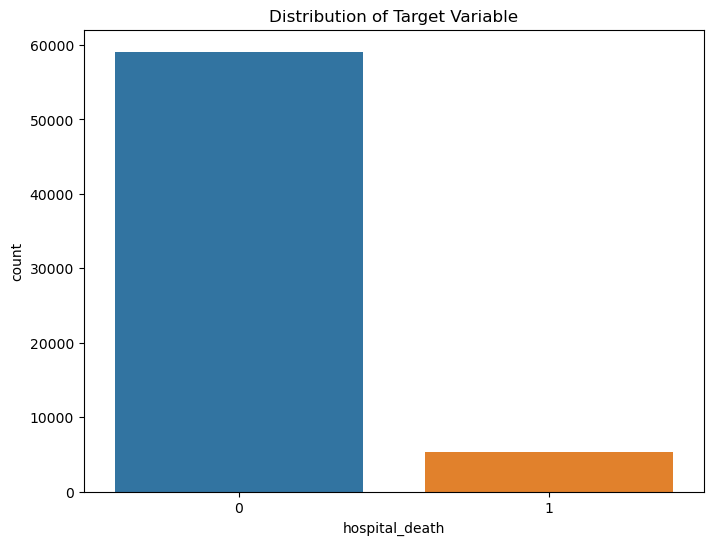

In [8]:
# Check target variable distribution
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_distribution(df, target_column):
    """
    Plot the distribution of the target variable.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        target_column (str): Name of the target column.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_column, data=df)
    plt.title('Distribution of Target Variable')
    plt.show()

# Usage:
plot_target_distribution(demographic_train, 'hospital_death')


Outlier detection for demographic:
Outlier detection for labs:
Outlier detection for vitals:


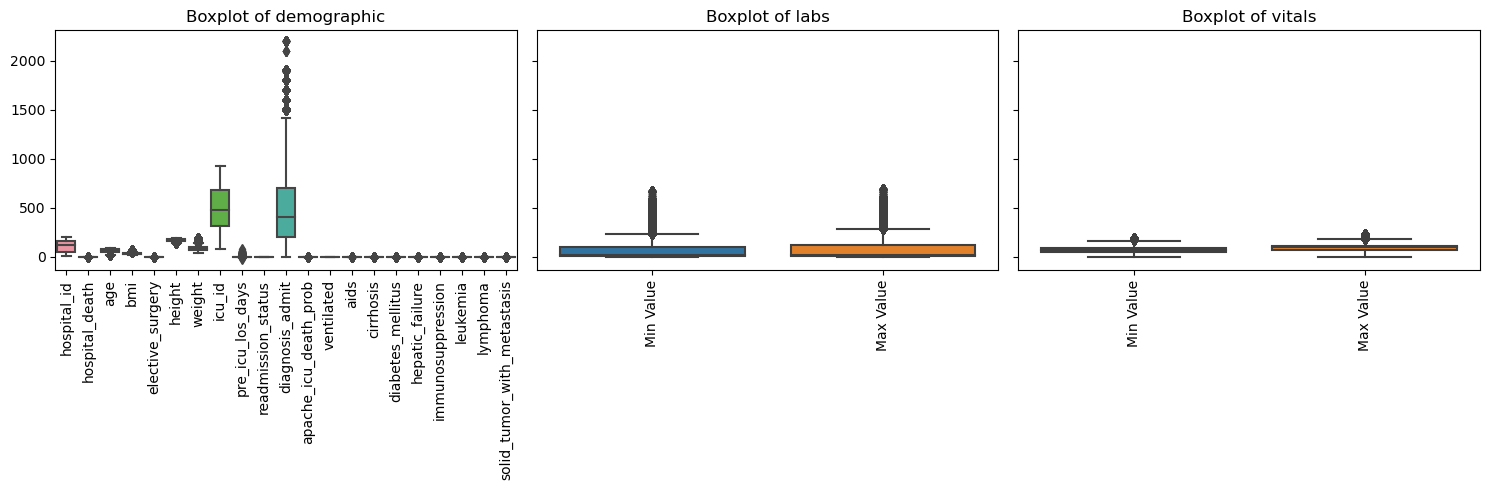

In [11]:
def detect_outliers(dataframes, names):
    """
    Detect outliers in given dataframes using box plots, excluding the 'patient_id' column.
    Plots will be arranged in a grid.

    Parameters:
        dataframes (list of pd.DataFrame): List of DataFrames to analyze.
        names (list of str): Names corresponding to each DataFrame in the list.

    Returns:
        None
    """
    num_dataframes = len(dataframes)
    fig, axes = plt.subplots(1, num_dataframes, figsize=(15, 5), sharey=True)

    for idx, (df, name) in enumerate(zip(dataframes, names)):
        print(f"Outlier detection for {name}:")

        # Drop the 'patient_id' column if it exists
        df_plot = df.drop(columns=['patient_id'], errors='ignore')

        sns.boxplot(ax=axes[idx], data=df_plot.select_dtypes(include=['float64', 'int64']))
        axes[idx].set_title(f'Boxplot of {name}')
        axes[idx].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# Usage:
dataframes = [demographic_train, labs_train, vitals_train]
names = ["demographic", "labs", "vitals"]
detect_outliers(dataframes, names)


## 2. Data cleaning

In [12]:

def demographic_fill_na(df):
    
    """
    Fill missing values in the demographic dataframe.

    Parameters:
        df (pd.DataFrame): Demographic DataFrame with missing values.

    Returns:
        pd.DataFrame: DataFrame with missing values filled.
    """
    # Weight and bmi and height are highly related, remove weight.
    df.drop('weight', axis=1, inplace=True)

    # Fill the null value in ethnicity column with "Other/Unknown"
    df['ethnicity'] = df['ethnicity'].fillna('Other/Unknown')

    #Fill the null value of gender with equal M and F
    # Define the choices and probabilities
    choices = ['M', 'F']
    probabilities = [0.5, 0.5]

    # Use np.random.choice to fill each missing value
    df.loc[df['gender'].isnull(), 'gender'] = np.random.choice(choices, size=df['gender'].isnull().sum(), p=probabilities)

    # Fill the null value in "hospital_admit_source" column with "Unknown"
    df['hospital_admit_source'] = df['hospital_admit_source'].fillna('Unknown')

    # Fill the null value in "icu_admit_source" column with "Floor"
    df['icu_admit_source'] = df['icu_admit_source'].fillna('Floor')

    # Fill the null value in "bodysystem_diagnosis_admit" column with "Unknown"
    df['bodysystem_diagnosis_admit'] = df['bodysystem_diagnosis_admit'].fillna('Unknown')
    return df
    
# remove unit of measure in labs and vitals, the unit of measure shouldn't have any predict power
def labs_vitals_process(labs, column):
    """
    Process the labs DataFrame by removing unit of measure and pivoting.

    Parameters:
        labs (pd.DataFrame): Labs DataFrame.

    Returns:
        pd.DataFrame: Processed labs DataFrame.
    """
    
    #remove unit of measure
    labs.drop('Unit of Measure', axis=1, inplace=True)
    #pivot table to get unique patient_id
    labs_pivot = labs.pivot_table(
        values=['Min Value', 'Max Value'],
        index='patient_id',
        columns=[column, 'Time of Measure (First Day or First Hour of Stay)']
    )
    #print(labs_pivot.columns)
    labs_pivot.reset_index(inplace=True)
    #print(labs_pivot.columns)
    labs_pivot.columns = ['patient_id' if col[0] == 'patient_id' else '_'.join(str(col).strip() for col in col) for col in labs_pivot.columns]
    return labs_pivot




In [13]:
# Define merge dataset function
def merge_datasets(df1, df2, df3, key):
    """
    Merge three dataframes on a given key.

    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames to be merged.
        key (str): Column name on which to merge.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    merged_df = pd.merge(df1, df2, on=key, how='inner')
    merged_df = pd.merge(merged_df, df3, on=key, how='inner')
    return merged_df


In [14]:
# Preprocess three dataframes and then merge together
def preprocess(demo, labs, vitals,key):
    demo = demographic_fill_na(demo)
    labs = labs_vitals_process(labs,'Lab')
    vitals = labs_vitals_process(vitals, 'Vital')
    #merge
    train = merge_datasets(demo,vitals,labs,key)
    return train

In [15]:
train = preprocess(demographic_train,labs_train,vitals_train, 'patient_id')
test = preprocess(demographic_test,vitals_test,labs_test,'patient_id')
y_train = train['hospital_death']
X_train = train.drop('hospital_death', axis=1)

In [16]:
X_train.shape

(61598, 111)

### 3. Fit on models

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
%pip install wandb

In [18]:
import wandb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
#sample data function to reduce calculation, RAM overflow
def sample_data(df, fraction, target_col='hospital_death'):
    # Group by the target column and sample fraction from each group
    sampled_df = df.groupby(target_col).apply(lambda x: x.sample(frac=fraction, random_state=42)).reset_index(drop=True)
    sampled_X = sampled_df.drop('hospital_death', axis=1)
    sampled_y = sampled_df['hospital_death']
    return sampled_X, sampled_y


In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Logistic Regressy hyperparamerters
logistic_params = {
    'classifier__max_iter': [1000, 5000, 10000]
}


# Random Forest hyperparameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting hyperparameters
gb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7]
}



# Define the fractions to try
fractions = [0.1, 0.2, 0.3]

# Define scoring dictionary
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1'
}

In [21]:
# Get numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()


In [22]:
def define_preprocessing(numerical_features, categorical_features):
    # Numerical columns processing pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    # Categorical columns processing pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    # Combine numerical and categorical preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor


In [23]:
# Call the function to create the preprocessor object
preprocessor = define_preprocessing(numerical_features, categorical_features)

# Define the pipelines to try
pipelines = [
    {"name": "Logistic Regression", "pipeline": Pipeline([('preprocessor', preprocessor),
                                                          ('classifier', LogisticRegression(class_weight='balanced'))]),
                                                            "params_grid": logistic_params},
   {"name": "Random Forest", "pipeline": Pipeline([('preprocessor', preprocessor),
                                                   ('classifier', RandomForestClassifier())]),
                                                    "params_grid": rf_params},

    {"name": "Gradient Boost", "pipeline": Pipeline([('preprocessor', preprocessor),
                                                     ('classifier', GradientBoostingClassifier())]),
                                                     "params_grid": gb_params},

]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV


In [25]:

# Helper function to fit the model with error handling
def fit_model(pipeline_dict, X_train, y_train):
    try:
        grid_search = GridSearchCV(pipeline_dict['pipeline'], pipeline_dict.get('params_grid', {}),
                                   cv=5, scoring=scoring, refit='f1_score')
        grid_search.fit(X_train, y_train)
        return grid_search
    except Exception as e:
        error_message = f"An error occurred while fitting the model {pipeline_dict['name']}: {e}"
        print(error_message)
        wandb.log({"error": error_message}) # Logging the error to W&B
        return None

# Helper function to evaluate the model with error handling
def evaluate_model(grid_search, X_val, y_val, model_name, fraction):
    if grid_search is None:
        error_message = f"Skipping evaluation for {model_name} due to an error during fitting."
        print(error_message)
        wandb.log({"error": error_message}) # Logging the error to W&B
        return

    try:
        y_pred = grid_search.predict(X_val)
        y_prob = grid_search.predict_proba(X_val)[:, 1]
        cm = confusion_matrix(y_val, y_pred)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        log_results(grid_search, cm, fpr, tpr, roc_auc, model_name, fraction)
    except Exception as e:
        error_message = f"An error occurred while evaluating the model {model_name}: {e}"
        print(error_message)
        wandb.log({"error": error_message}) # Logging the error to W&B

def log_results(grid_search, cm, fpr, tpr, roc_auc, model_name, fraction):
    """Log results to W&B, including confusion matrix, ROC curve, and feature importances."""
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix for {model_name} with fraction {fraction}")
    confusion_matrix_image = plt.gcf()
    plt.close()

    # Plot ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with fraction {fraction}')
    plt.legend(loc="lower right")
    roc_curve_image = plt.gcf()
    plt.close()

    # Log the results
    wandb.log({
        "model_name": model_name,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
        "confusion_matrix": wandb.Image(confusion_matrix_image),
        "roc_curve": wandb.Image(roc_curve_image),
        "precision": grid_search.cv_results_['mean_test_precision'].mean(),
        "recall": grid_search.cv_results_['mean_test_recall'].mean(),
        "f1_score": grid_search.cv_results_['mean_test_f1_score'].mean(),
        "fraction": fraction
    })





In [ ]:
def train_and_evaluate(pipelines, fractions, train_data):
    results = []  # To store evaluation results

    # Initialize W&B
    wandb.init(project="EHR_record2")

    # Loop over the pipelines and fractions
    for pipeline_dict in pipelines:
        for fraction in fractions:
            print(f"Training {pipeline_dict['name']} with fraction {fraction}")
            X_sampled, y_sampled = sample_data(train_data, fraction)
            X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, stratify=y_sampled, test_size=0.2)

            # Fit the model
            grid_search = fit_model(pipeline_dict, X_train, y_train)


            # Evaluate the model
            evaluation_result = evaluate_model(grid_search, X_val, y_val, pipeline_dict['name'], fraction)

            # Append to results
            results.append({'name': pipeline_dict['name'], 'fraction': fraction, 'score': evaluation_result, 'model': grid_search.best_estimator_})

    # Sort results by the desired metric
    results.sort(key=lambda x: x['score'], reverse=True)

    # Refit the best model
    best_model = results[0]['model']
    best_model.fit(X_train_combined, y_train_combined)  # X_train_combined and y_train_combined should include both train and validation data

    return best_model




In [ ]:
#Train and evaluate model
best_model = train_and_evaluate(pipelines, fractions, train_data)


In [ ]:
# process test data
predictions = best_model.predict(test)  # Predict on the test data

In [ ]:

#Train and evaluate model
train_and_evaluate(pipelines, fractions, train)

wandb: Currently logged in as: xin0558. Use `wandb login --relogin` to force relogin


Training Logistic Regression with fraction 0.1
Training Logistic Regression with fraction 0.2
Training Logistic Regression with fraction 0.3
Training Random Forest with fraction 0.1
Training Random Forest with fraction 0.2
Training Random Forest with fraction 0.3
Training Gradient Boost with fraction 0.1
Training Gradient Boost with fraction 0.2
Training Gradient Boost with fraction 0.3


In [ ]:
#export data
api = wandb.Api()
run = api.run("/xin0558/EHR_record/runs/smqk3dpb")
Show history data:

print(run.history())